In [1]:
import pandas as pd

patient = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Patient.csv")
lab = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Lab.csv")
lab_patient_merged = pd.merge(patient, lab, on = "Patient_ID", how = 'inner')

lab_patient_merged['Site_ID'] = lab_patient_merged['Site_ID_x'].combine_first(lab_patient_merged['Site_ID_y'])
lab_patient_merged.drop(['Site_ID_x', 'Site_ID_y'], axis=1, inplace=True)

lab_patient_merged['DateCreated'] = pd.to_datetime(lab_patient_merged['DateCreated'])
lab_patient_merged['YearCreated'] = lab_patient_merged['DateCreated'].dt.year

C:\Users\suzielee\AppData\Local\Temp\ipykernel_4272\4245242311.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  lab = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Lab.csv")


In [2]:
#Sex distribution of the overall population before filter 
total_male = lab_patient_merged[lab_patient_merged['Sex'] == 'Male']['Patient_ID'].nunique()
total_female = lab_patient_merged[lab_patient_merged['Sex'] == 'Female']['Patient_ID'].nunique()
total_patients = lab_patient_merged['Patient_ID'].nunique()
missing_gender_count = lab_patient_merged[lab_patient_merged['Sex'].isna()]['Patient_ID'].nunique()

summary_data = {
    'Sex': ['Female', 'Male', 'Other'],
    'Total Count': [total_female, total_male, missing_gender_count],
}

summary_df = pd.DataFrame(summary_data)

total_patients = total_female + total_male + missing_gender_count
summary_df['Proportion'] = summary_df['Total Count'] / total_patients
print(summary_df)

      Sex  Total Count  Proportion
0  Female        73820    0.552864
1    Male        59630    0.446590
2   Other           73    0.000547


In [3]:
import numpy as np
lab_patient_merged['DateCreated'] = pd.to_datetime(lab_patient_merged['DateCreated'])

mask = ~lab_patient_merged[['DateCreated', 'BirthYear']].isnull().any(axis=1)
lab_patient_merged['Age'] = np.nan
lab_patient_merged.loc[mask, 'Age'] = (
    (lab_patient_merged.loc[mask, 'DateCreated'] - 
    pd.to_datetime(lab_patient_merged.loc[mask, 'BirthYear'].astype(str) + '-06-01'))
    .dt.days // 365
)

lab_patient_merged = lab_patient_merged[lab_patient_merged['Age'] >= 6]

C:\Users\suzielee\AppData\Local\Temp\ipykernel_4272\2664049703.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  lab_patient_merged.loc[mask, 'Age'] = (


In [4]:
ferritin_lab = lab_patient_merged[lab_patient_merged['Code_calc'] == "2276-4"]
ferritin_lab_short = ferritin_lab[['Patient_ID', 'Sex', 'Site_ID', 'TestResult_calc', 'DateCreated', 'YearCreated', 'Age']].copy()

In [5]:
total_unique_patients = ferritin_lab_short['Patient_ID'].nunique()
print("Total Number of Unique Patients:", total_unique_patients)

#Tally by sex
female_count = ferritin_lab_short[ferritin_lab_short['Sex'] == 'Female']['Patient_ID'].nunique()
male_count = ferritin_lab_short[ferritin_lab_short['Sex'] == 'Male']['Patient_ID'].nunique()
missing_gender_count = total_unique_patients - (female_count + male_count)

print("Total Number of Female:", female_count, "Total Number of Male:", male_count, "Total Number of Missing/Unspecified Gender:", missing_gender_count)


Total Number of Unique Patients: 94264
Total Number of Female: 58007 Total Number of Male: 36213 Total Number of Missing/Unspecified Gender: 44


In [6]:
Grouped_year_sex = ferritin_lab_short.groupby(['YearCreated', 'Sex'])['Patient_ID'].nunique().reset_index()
Grouped_year_sex = Grouped_year_sex.rename(columns={'Patient_ID': 'Count'})
Grouped_year_sex['TotalCount'] = Grouped_year_sex.groupby('YearCreated')['Count'].transform('sum')
Grouped_year_sex['Proportion'] = Grouped_year_sex['Count'] / Grouped_year_sex['TotalCount']
print(Grouped_year_sex)

    YearCreated     Sex  Count  TotalCount  Proportion
0          2010  Female   9088       13022    0.697896
1          2010    Male   3934       13022    0.302104
2          2011  Female  10065       14544    0.692038
3          2011    Male   4479       14544    0.307962
4          2012  Female  11003       16206    0.678946
5          2012    Male   5203       16206    0.321054
6          2013  Female  12401       18745    0.661563
7          2013    Male   6344       18745    0.338437
8          2014  Female  13140       19832    0.662566
9          2014    Male   6692       19832    0.337434
10         2015  Female  13017       19414    0.670496
11         2015    Male   6397       19414    0.329504
12         2016  Female  13282       20177    0.658274
13         2016    Male   6895       20177    0.341726
14         2017  Female  13461       20628    0.652560
15         2017    Male   7167       20628    0.347440
16         2018  Female  14587       22344    0.652837
17        

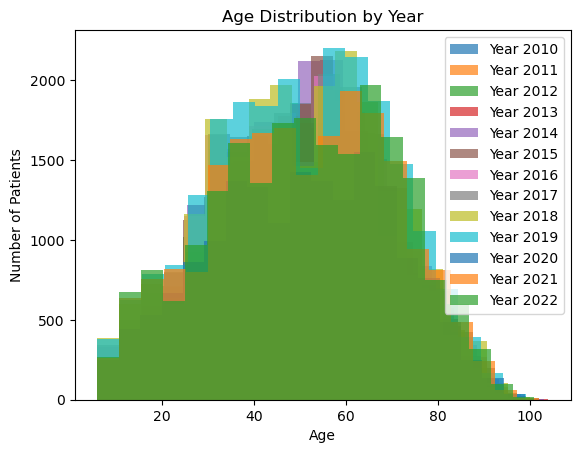

In [7]:
unique_age_per_patient = ferritin_lab_short.groupby(['YearCreated', 'Patient_ID'])['Age'].first().reset_index()
import matplotlib.pyplot as plt

for year in unique_age_per_patient['YearCreated'].unique():
    plt.hist(unique_age_per_patient[unique_age_per_patient['YearCreated'] == year]['Age'], bins=20, alpha=0.7, label=f"Year {year}")
    
plt.title('Age Distribution by Year')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.legend(loc="upper right")
plt.show()


In [8]:
unique_age_per_patient = ferritin_lab_short.groupby(['YearCreated', 'Patient_ID'])['Age'].first().reset_index()
mean_age_per_year = unique_age_per_patient.groupby('YearCreated')['Age'].mean()
std_age_per_year = unique_age_per_patient.groupby('YearCreated')['Age'].std()

data = {
    'Mean Age': mean_age_per_year,
    'Sample SD Age': std_age_per_year
}
summary_df = pd.DataFrame(data)

print(summary_df)

              Mean Age  Sample SD Age
YearCreated                          
2010         47.896345      17.951401
2011         48.043858      18.053562
2012         48.755615      18.155980
2013         49.271442      18.107114
2014         49.544685      18.129540
2015         49.278696      18.210785
2016         48.778565      18.713723
2017         49.472350      18.823642
2018         49.494945      19.068235
2019         49.947994      19.260846
2020         50.214047      19.565863
2021         50.328638      19.524015
2022         50.921760      19.757065


In [9]:
# Since data is longitudinal, just doing mean of overall dataset may have patient with multiple encounters overrepresented in the dataset for final mean. Therefore, took mean of each patient's age to represent their age most accurately. Then took range, mean, and median of the all of the patients to best represent study population. 
mean_age_per_patient_year = ferritin_lab_short.groupby(['YearCreated', 'Patient_ID'])['Age'].mean().reset_index()
patient_aggregated_data = mean_age_per_patient_year.groupby('Patient_ID')['Age'].agg(['mean', 'median']).reset_index()
overall_mean_age = patient_aggregated_data['mean'].mean()
overall_median_age = patient_aggregated_data['median'].median()

std_mean_age = patient_aggregated_data['mean'].std()
iqr_median_age = np.percentile(patient_aggregated_data['median'], 75) - np.percentile(patient_aggregated_data['median'], 25)

print("Overall Mean Age:", overall_mean_age)
print("Standard Deviation of Mean Age:", std_mean_age)
print("Overall Median Age:", overall_median_age)
print("IQR Median Age:", iqr_median_age)
print("Min Age:", ferritin_lab['Age'].min(), "Max Age:", ferritin_lab['Age'].max())



Overall Mean Age: 45.86763206837815
Standard Deviation of Mean Age: 19.724782407388172
Overall Median Age: 45.5
IQR Median Age: 29.64393939393939
Min Age: 6 Max Age: 104


In [10]:
total_female = ferritin_lab_short[ferritin_lab_short['Sex'] == 'Female']['Patient_ID'].nunique()
total_male = ferritin_lab_short[ferritin_lab_short['Sex'] == 'Male']['Patient_ID'].nunique()
missing_gender_count = ferritin_lab_short[ferritin_lab_short['Sex'].isna()]['Patient_ID'].nunique()

# Create a DataFrame for the summary
summary_data = {
    'Sex': ['Female', 'Male', 'Other'],
    'Total Count': [total_female, total_male, missing_gender_count],
}

summary_df = pd.DataFrame(summary_data)

total_patients = total_female + total_male + missing_gender_count
summary_df['Proportion'] = summary_df['Total Count'] / total_patients
print(summary_df)


      Sex  Total Count  Proportion
0  Female        58007    0.615367
1    Male        36213    0.384166
2   Other           44    0.000467


In [11]:
rural = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Site.csv")

patient_demo_rural = pd.merge(rural, ferritin_lab_short, on = 'Site_ID', how='inner')
unique_patients_by_urban_rural = patient_demo_rural.groupby('UrbanRural')['Patient_ID'].nunique()

total_urban = patient_demo_rural[patient_demo_rural['UrbanRural'] == 'U']['Patient_ID'].nunique()
total_rural = patient_demo_rural[patient_demo_rural['UrbanRural'] == 'R']['Patient_ID'].nunique()
missing_urban_rural_count = patient_demo_rural[patient_demo_rural['UrbanRural'].isna()]['Patient_ID'].nunique()

print("Total Number of Missing/Unspecified UrbanRural Category:", missing_urban_rural_count)

summary_data = {
    'UrbanRural': ['Urban', 'Rural', 'Other'],
    'Total Count': [total_urban, total_rural, missing_urban_rural_count],
}

summary_df = pd.DataFrame(summary_data)

total_patients = total_urban + total_rural + missing_urban_rural_count
summary_df['Proportion'] = summary_df['Total Count'] / total_patients
print(summary_df)


Total Number of Missing/Unspecified UrbanRural Category: 0
  UrbanRural  Total Count  Proportion
0      Urban        82345    0.873557
1      Rural        11919    0.126443
2      Other            0    0.000000


In [12]:
Exam = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Exam.csv")
BMI = Exam[Exam['Exam1_calc'] == "BMI"]
BMI.drop(['Exam2_calc', 'Result2_calc'], axis=1, inplace=True)
BMI.rename(columns={'Result1_calc': 'BMI_value'}, inplace=True)

#Filtering BMI values within the range of 10 and 80 because outside of that might be false data
BMI = BMI[(BMI['BMI_value'] >= 10) & (BMI['BMI_value'] <= 80)]
BMI.reset_index(drop=True, inplace=True)
BMI['DateCreated'] = pd.to_datetime(BMI['DateCreated'])
BMI['YearCreated'] = BMI['DateCreated'].dt.year

#Merging on YearCreated to capture the most closest correlation between ID status & BMI in the same year. Also making sure BMI per unique patient, so that certain patients are not overrepressented in data due to multiple encounters.
BMI_merge = pd.merge(ferritin_lab_short, BMI[['Patient_ID', 'YearCreated', 'BMI_value']], on=['Patient_ID', 'YearCreated'], how='left')
median_bmi_per_patient_year = BMI_merge.groupby(['Patient_ID', 'YearCreated'])['BMI_value'].median().reset_index()
#Median BMI aggregate per unique patient across all years
median_bmi_per_patient = median_bmi_per_patient_year.groupby('Patient_ID')['BMI_value'].median().reset_index()
#Overall median of the aggregated BMI values
overall_median_bmi = median_bmi_per_patient['BMI_value'].median()

Q1 = median_bmi_per_patient['BMI_value'].quantile(0.25)
Q3 = median_bmi_per_patient['BMI_value'].quantile(0.75)
IQR = Q3 - Q1

print("Overall Median of Aggregated BMI Values:", overall_median_bmi)
print("IQR of Aggregated Median BMI Values:", IQR)


C:\Users\suzielee\AppData\Local\Temp\ipykernel_4272\1819562445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMI.drop(['Exam2_calc', 'Result2_calc'], axis=1, inplace=True)
C:\Users\suzielee\AppData\Local\Temp\ipykernel_4272\1819562445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMI.rename(columns={'Result1_calc': 'BMI_value'}, inplace=True)


Overall Median of Aggregated BMI Values: 26.549999999999997
IQR of Aggregated Median BMI Values: 7.899999999999999


In [13]:
depr = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Deprivation.csv")

depr['mat1'] = (1*depr['MaterialQ1'])/100
depr['mat2'] = (2 * depr['MaterialQ2']) / 100
depr['mat3'] = (3 * depr['MaterialQ3']) / 100
depr['mat4'] = (4 * depr['MaterialQ4']) / 100
depr['mat5'] = (5 * depr['MaterialQ5']) / 100

depr['matdeptotal'] = depr[['mat1', 'mat2', 'mat3', 'mat4', 'mat5']].sum(axis=1)

dep_pt_merged = pd.merge(depr[['Patient_ID', 'matdeptotal']], ferritin_lab_short, on = "Patient_ID", how = 'inner')
print(dep_pt_merged.head())

   Patient_ID  matdeptotal     Sex  Site_ID TestResult_calc DateCreated  \
0   100000016          1.0    Male        4           290.0  2018-03-26   
1   100000016          1.0    Male        4           315.0  2022-01-25   
2   100000016          1.0    Male        4           367.0  2014-11-24   
3   100000033          3.3  Female        1            35.0  2013-12-11   
4   100000054          5.0    Male        1            50.0  2010-03-31   

   YearCreated  Age  
0         2018   52  
1         2022   56  
2         2014   49  
3         2013    6  
4         2010   60  


In [14]:
unique_SES_pt = dep_pt_merged.drop_duplicates(subset='Patient_ID')
summary_stats = unique_SES_pt['matdeptotal'].agg(['mean', 'median', 'std', 'quantile', 'max', 'min'])
print(summary_stats)


mean        2.337259
median      2.000000
std         1.322943
quantile    2.000000
max         5.000000
min         0.000000
Name: matdeptotal, dtype: float64


In [15]:
unique_SES_pt = dep_pt_merged.drop_duplicates(subset='Patient_ID')
summary_stats = unique_SES_pt['matdeptotal'].agg([
    'mean', 
    'median', 
    'std', 
    lambda x: x.quantile(0.75) - x.quantile(0.25), 
    'max', 
    'min'
])
print(summary_stats)


mean        2.337259
median      2.000000
std         1.322943
<lambda>    2.420000
max         5.000000
min         0.000000
Name: matdeptotal, dtype: float64


In [16]:
unique_patients_with_age = ferritin_lab_short[ferritin_lab_short['Age'].notna()]['Patient_ID'].nunique()
print("unique_patients_age", unique_patients_with_age)
print("unique_SES", unique_SES_pt[unique_SES_pt['matdeptotal'].notna()]['Patient_ID'].nunique())
print(unique_SES_pt['Patient_ID'].nunique())
print("patient_demo_rural", patient_demo_rural[patient_demo_rural['UrbanRural'].notna()]['Patient_ID'].nunique())
print(patient_demo_rural['Patient_ID'].nunique())
print("BMI", BMI_merge[BMI_merge['BMI_value'].notna()]['Patient_ID'].nunique())
print(BMI_merge['Patient_ID'].nunique())


unique_patients_age 94264
unique_SES 82682
82682
patient_demo_rural 94264
94264
BMI 69721
94264
